In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
dataset_train = pd.read_csv('Salestrain.csv')

In [3]:
dataset_train.shape

(96, 1)

In [6]:
dataset_train

,data
0,112
1,118
2,132
3,129
4,121
...,...
91,405
92,355
93,306
94,271


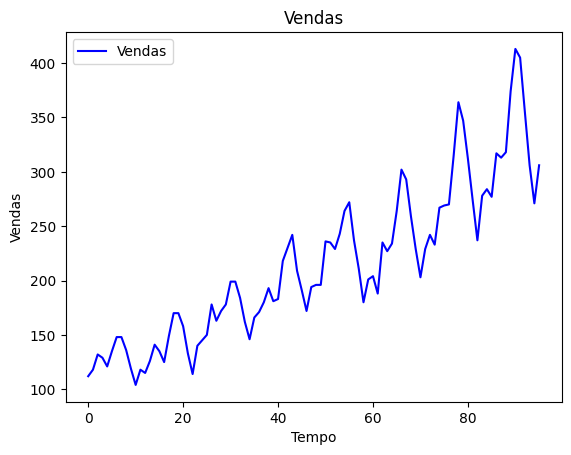

In [5]:
plt.plot(dataset_train, color='blue', label='Vendas')
plt.title("Vendas")
plt.xlabel("Tempo")
plt.ylabel("Vendas")
plt.legend()
plt.show()

In [7]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(dataset_train)

In [8]:
X_train = []
y_train = []
for i in range(90, len(training_set_scaled)):
  data = training_set_scaled[i-90:i,0]
  X_train.append(data)
  y_train.append(training_set_scaled[i,0])
X_train = np.array(X_train).reshape(-1,90,1)
y_train = np.array(y_train)

In [10]:
modelo = Sequential()
modelo.add(LSTM(units=100, return_sequences = True, input_shape= (X_train.shape[1],1)))
modelo.add(Dropout(0.2))
modelo.add(LSTM(units=100, return_sequences = True))
modelo.add(Dropout(0.2))
modelo.add(LSTM(units=100, return_sequences = True))
modelo.add(Dropout(0.2))
modelo.add(LSTM(units=100))
modelo.add(Dropout(0.2))
modelo.add(Dense(units=1))

In [12]:
modelo.compile(optimizer="adam", loss="mean_squared_error")
modelo.fit(X_train, y_train, epochs=300, batch_size=1)

Epoch 1/300
6/6 [==============================] - 8s 116ms/step - loss: 0.2006
Epoch 2/300
6/6 [==============================] - 1s 117ms/step - loss: 0.0795
Epoch 3/300
6/6 [==============================] - 1s 115ms/step - loss: 0.0538
Epoch 4/300
6/6 [==============================] - 1s 113ms/step - loss: 0.0498
Epoch 5/300
6/6 [==============================] - 1s 121ms/step - loss: 0.0514
Epoch 6/300
6/6 [==============================] - 1s 113ms/step - loss: 0.0378
Epoch 7/300
6/6 [==============================] - 1s 114ms/step - loss: 0.0487
Epoch 8/300
6/6 [==============================] - 1s 118ms/step - loss: 0.0433
Epoch 9/300
6/6 [==============================] - 1s 113ms/step - loss: 0.0562
Epoch 10/300
6/6 [==============================] - 1s 181ms/step - loss: 0.0884
Epoch 11/300
6/6 [==============================] - 1s 191ms/step - loss: 0.0414
Epoch 12/300
6/6 [==============================] - 1s 117ms/step - loss: 0.0398
Epoch 13/300
6/6 [===================

In [13]:
dataset_test = pd.read_csv("Salestest.csv")

In [14]:
dataset_test.shape

(48, 1)

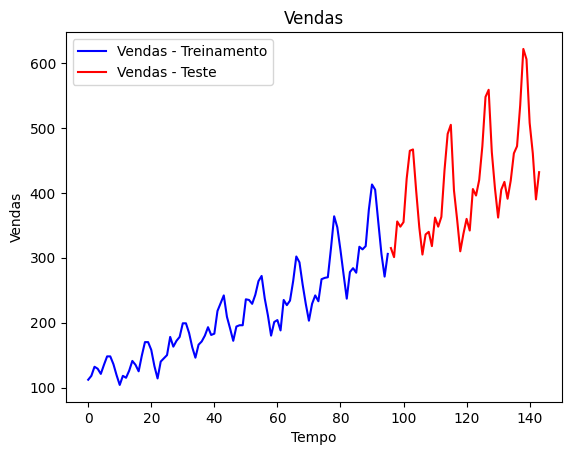

In [15]:
train_values = dataset_train['data'].values
test_values = dataset_test['data'].values
total_values = np.concatenate((train_values, test_values), axis=0)
time_index = range(len(total_values))
plt.plot(time_index[:len(train_values)], train_values, color='blue', label='Vendas - Treinamento')
plt.plot(time_index[len(train_values):], test_values, color='red', label="Vendas - Teste")
plt.title("Vendas")
plt.xlabel("Tempo")
plt.ylabel("Vendas")
plt.legend()
plt.show()


In [17]:
dataset_test_anomalies = dataset_test.copy()
dataset_test_anomalies.loc[:9,'data'] = 90
dataset_test_anomalies.loc[10:34, 'data'] = np.random.uniform(100,200, size=(25,))
dataset_test_anomalies.loc[35:, 'data'] = 90

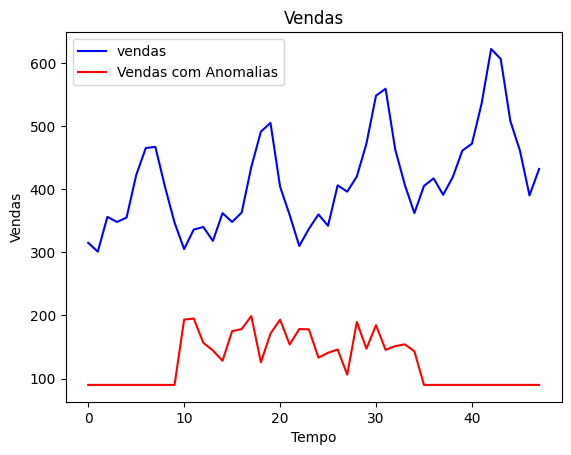

In [18]:
plt.plot(dataset_test, color='blue', label='vendas')
plt.plot(dataset_test_anomalies, color='red', label='Vendas com Anomalias')
plt.title("Vendas")
plt.xlabel("Tempo")
plt.ylabel("Vendas")
plt.legend()
plt.show()

In [19]:
dataset_total = pd.concat((dataset_train['data'], dataset_test['data']), axis=0)
inputs = dataset_total[len(dataset_total)-len(dataset_test)-90:]
inputs = pd.DataFrame(inputs, columns=['data'])
inputs = sc.transform(inputs)

In [42]:
dataset_total_anomalies = pd.concat((dataset_train['data'], dataset_test_anomalies['data']), axis=0)
inputs_anomalies = dataset_total_anomalies[len(dataset_total_anomalies)-len(dataset_test_anomalies)-90:]
inputs_anomalies = pd.DataFrame(inputs_anomalies, columns=['data'])
inputs_anomalies = sc.transform(inputs_anomalies)

In [43]:
X_test = []
X_test_anomalies = []
for i in range(90, len(inputs)):
  X_test.append(inputs[i-90:i,0])
  X_test_anomalies.append(inputs_anomalies[i-90:i,0])
X_test, X_test_anomalies = np.array(X_test), np.array(X_test_anomalies)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_test_anomalies = np.reshape(X_test_anomalies, (X_test_anomalies.shape[0], X_test_anomalies.shape[1],1))

In [44]:
predicted_sales = modelo.predict(X_test)
predicted_sales = sc.inverse_transform(predicted_sales)

predicted_sales_anomalies = modelo.predict(X_test_anomalies)
predicted_sales_anomalies = sc.inverse_transform(predicted_sales_anomalies)

mes_test = mean_squared_error(test_values, predicted_sales)
mes_test_anomalies = mean_squared_error(test_values, predicted_sales_anomalies)

2/2 [==============================] - 0s 66ms/step


In [45]:
print(f"MSE para os dados normais: {mes_test}")
print(f"MSE para os dados com anomalias {mes_test_anomalies}")

MSE para os dados normais: 6749.77228920638
MSE para os dados com anomalias 14444.699917041178


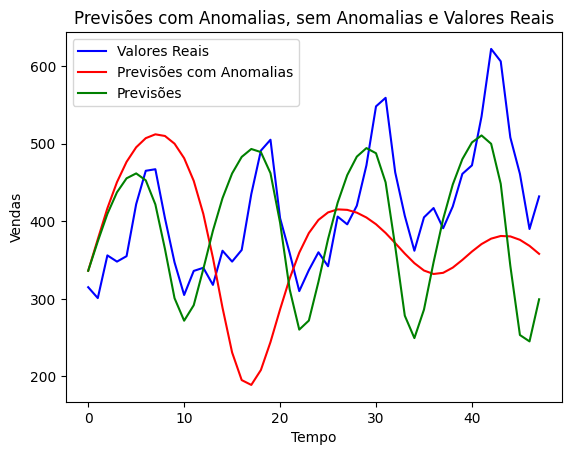

In [46]:
plt.plot(test_values, color='blue', label='Valores Reais')
plt.plot(predicted_sales_anomalies, color='red', label='Previsões com Anomalias')
plt.plot(predicted_sales, color='green', label='Previsões')
plt.title('Previsões com Anomalias, sem Anomalias e Valores Reais')
plt.xlabel("Tempo")
plt.ylabel("Vendas")
plt.legend()
plt.show()